<a href="https://colab.research.google.com/github/simranbhadouria/International-Debt-Analysis-EDA--Project1/blob/main/International_Debt_Analysis_EDA_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

International Debt Analysis Project
-----------------------------------
Motive:
- To analyze international debt trends across countries and indicators.
- To identify which countries/indicators hold the highest debt burden.
- To generate useful insights for policy makers, analysts, and researchers.

In [88]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


In [89]:
file_path = "/content/sample_data/international_debt.csv"

#Load dataset

In [90]:
df = pd.read_csv(file_path)

# Rename columns for SQL safety

In [91]:
df = df.rename(columns={
    "country_name": "country",
    "country_code": "code",
    "indicator_name": "indicator",
    "indicator_code": "indicator_code",
    "debt": "debt"
})

# Convert debt column to numeric

In [92]:
df["debt"] = pd.to_numeric(df["debt"], errors="coerce")
df = df.dropna(subset=["country", "indicator", "debt"])


# Save into SQLite Database

In [93]:
conn = sqlite3.connect("debt.db")
df.to_sql("international_debt", conn, index=False, if_exists="replace")


2357

# SQL Queries

In [94]:
queries = {
    "distinct_countries": "SELECT COUNT(DISTINCT country) AS distinct_countries FROM international_debt;",
    "distinct_indicators": "SELECT COUNT(DISTINCT indicator) AS distinct_indicators FROM international_debt;",
    "total_debt": "SELECT SUM(debt) AS total_debt FROM international_debt;",
    "country_highest_debt": """
        SELECT country, SUM(debt) AS total_debt
        FROM international_debt
        GROUP BY country
        ORDER BY total_debt DESC
        LIMIT 1;
    """,
    "avg_debt_per_indicator": """
        SELECT indicator, AVG(debt) AS avg_debt
        FROM international_debt
        GROUP BY indicator
        ORDER BY avg_debt DESC;
    """,
    "highest_principal_repayment": """
        SELECT country, indicator, MAX(debt) AS highest_principal_repayment
        FROM international_debt
        WHERE LOWER(indicator) LIKE '%principal%' OR LOWER(indicator) LIKE '%repay%'
        GROUP BY country, indicator
        ORDER BY highest_principal_repayment DESC
        LIMIT 1;
    """,
    "most_common_indicator": """
        SELECT indicator, COUNT(*) AS frequency
        FROM international_debt
        GROUP BY indicator
        ORDER BY frequency DESC
        LIMIT 1;
    """
}

# Execute queries

In [95]:
results = {}
for name, query in queries.items():
    results[name] = pd.read_sql(query, conn)

# Export Results to Excel

In [96]:
with pd.ExcelWriter("Debt_EDA_Results.xlsx", engine="openpyxl") as writer:
    for name, df_out in results.items():
        df_out.to_excel(writer, sheet_name=name, index=False)
    df.to_excel(writer, sheet_name="Raw_Data", index=False)

print("[INFO] Results exported to Debt_EDA_Results.xlsx")

[INFO] Results exported to Debt_EDA_Results.xlsx


# Visualizations

In [97]:
os.makedirs("outputs", exist_ok=True)

# 1. Top 10 countries by total debt

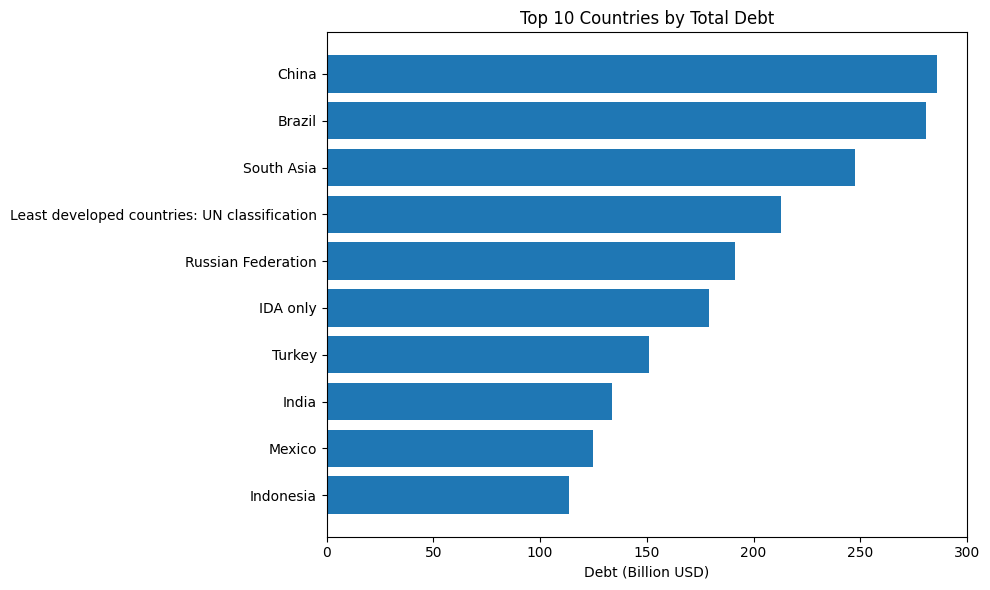

In [98]:
q_top10 = """
SELECT country, SUM(debt) AS total_debt
FROM international_debt
GROUP BY country
ORDER BY total_debt DESC
LIMIT 10;
"""
top10 = pd.read_sql(q_top10, conn)

plt.figure(figsize=(10,6))
plt.barh(top10["country"][::-1], top10["total_debt"][::-1] / 1e9)
plt.xlabel("Debt (Billion USD)")
plt.title("Top 10 Countries by Total Debt")
plt.tight_layout()
plt.savefig("outputs/top10_countries.png")
plt.show()
plt.close()


# 2. Top 10 indicators by average debt

/tmp/ipython-input-3148361256.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


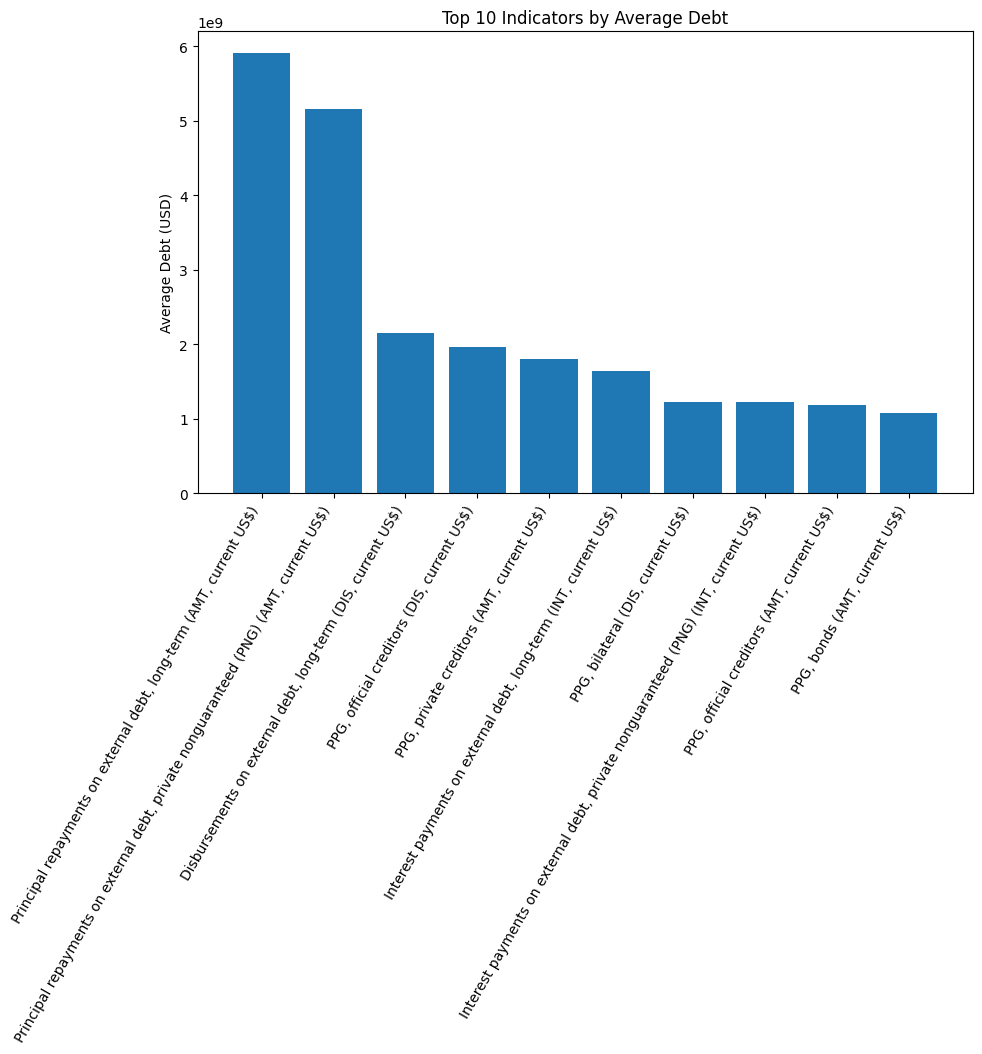

In [99]:
avg10 = results["avg_debt_per_indicator"].head(10)
plt.figure(figsize=(10,6))
plt.bar(avg10["indicator"], avg10["avg_debt"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Average Debt (USD)")
plt.title("Top 10 Indicators by Average Debt")
plt.tight_layout()
plt.savefig("outputs/top10_indicators.png")
plt.show()
plt.close()


# 3. Debt distribution (Histogram)

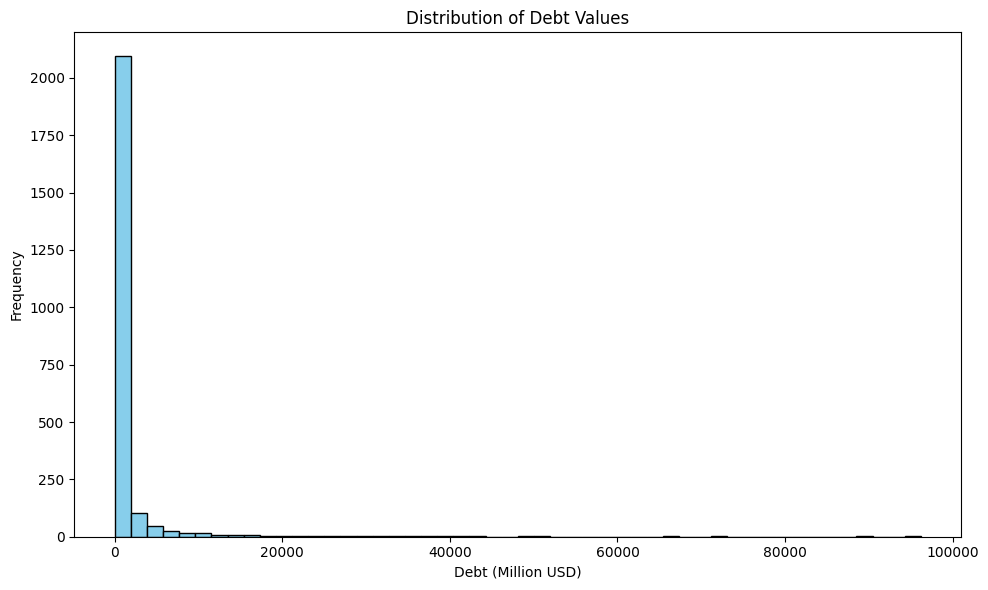

In [100]:
plt.figure(figsize=(10,6))
plt.hist(df["debt"] / 1e6, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Debt (Million USD)")
plt.ylabel("Frequency")
plt.title("Distribution of Debt Values")
plt.tight_layout()
plt.savefig("outputs/debt_distribution.png")
plt.show()
plt.close()

# 4. Pie chart – Debt share of top 5 countries

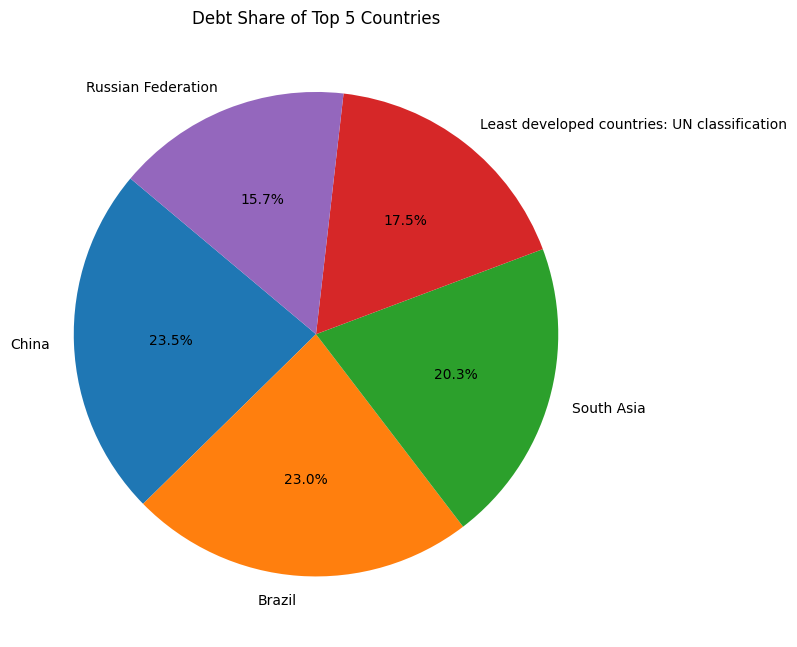

In [101]:
top5 = top10.head(5)
plt.figure(figsize=(8,8))
plt.pie(top5["total_debt"], labels=top5["country"], autopct="%1.1f%%", startangle=140)
plt.title("Debt Share of Top 5 Countries")
plt.tight_layout()
plt.savefig("outputs/debt_pie.png")
plt.show()
plt.close()


# 5. Heatmap – Top 5 countries × Top 5 indicators

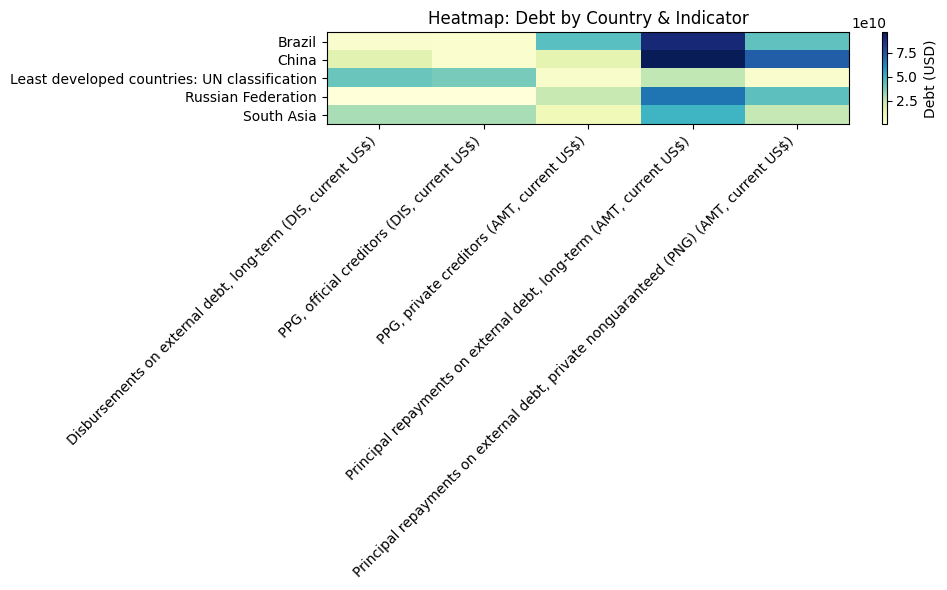

In [102]:
top_countries = top10["country"].head(5).tolist()
top_indicators = avg10["indicator"].head(5).tolist()

pivot = df[df["country"].isin(top_countries) & df["indicator"].isin(top_indicators)]
pivot_table = pivot.pivot_table(values="debt", index="country", columns="indicator", aggfunc="sum")

plt.figure(figsize=(10,6))
plt.imshow(pivot_table, cmap="YlGnBu", aspect="auto")
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns, rotation=45, ha="right")
plt.yticks(range(len(pivot_table.index)), pivot_table.index)
plt.colorbar(label="Debt (USD)")
plt.title("Heatmap: Debt by Country & Indicator")
plt.tight_layout()
plt.savefig("outputs/debt_heatmap.png")
plt.show()
plt.close()


In [103]:
conn.close()
